In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
class_name = "03211117"
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_img_dir = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

instances = instances[10:25]
print(instances)
print(cfg)

['dada218e78c9c81e2250bf58700b4d8f', 'dbcd5a88a9d4f1d7579cfe4420588034', 'f5f5e872bf70f59983f551e0fd7d32ac', 'f3bfeab806cc976072052f2ed83934f0', 'df8e098d4dbcb5b2ccc4d915989bc424', 'e1eac12837bcadcf44d2fe7d13c65f0c', 'ffc224f284b63b17b0f6d70666df2668', 'd9bac9c418667d2ba62bc668cb34e698', 'e2787b2f0dd35fccf42a90fe4baf4591', 'df35d335e76abf5618ba239e198ef2ba', 'ff62121443345bf76cff78602fbd834e', 'f3d6470b3f4f5ad71c7075c2bc313334', 'fe3e7a35b8a1c06d3bb4a1304fe504d3', 'd7b87d0083bf5568fd28950562697757', 'fb1ca7e50ec3013b493a838ac2ced544']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'model': {'point_encoder': 'ResnetPointnet', 'image_encoder': 'Resnet18', 'deformation_decoder': 'FCStandard', 'latent_dim_pointnet': 512, 'latent_dim_resnet': 256, 'decoder_dim': 10

dada218e78c9c81e2250bf58700b4d8f


/home/svcl-oowl/brandon/research/sil_consistent_at_inference/evaluation.py:73: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427286/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  input_img_mask = torch.tensor(np.asarray(input_img))[:,:,3] > 0


Input mesh metrics: {'2d_iou_input': 0.11213099956512451, '2d_iou_multi': 0.15318009288360676, '3d_iou': 0.0005681011, '3d_iou_norm': 0, 'chamfer_L1': 0.16890358924865723, 'chamfer_L1_norm': 0}
0.5641025900840759 85.2631607055664 170.5263214111328


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Refined mesh metrics: {'2d_iou_input': 0.11576758325099945, '2d_iou_multi': 0.17953504590938488, '3d_iou': 0.0014515703, '3d_iou_norm': 0, 'chamfer_L1': 0.1578761637210846, 'chamfer_L1_norm': 0}


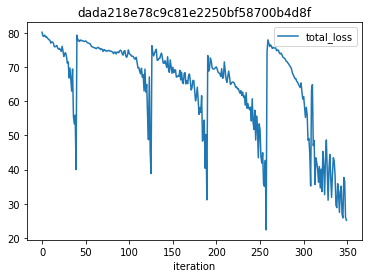

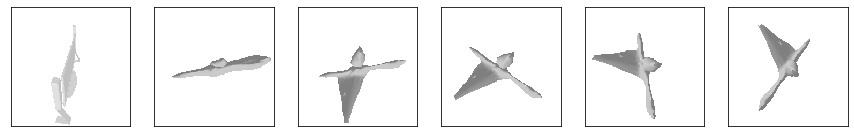

dbcd5a88a9d4f1d7579cfe4420588034
Input mesh metrics: {'2d_iou_input': 0.8549615144729614, '2d_iou_multi': 0.6955512041846911, '3d_iou': 0.15875806, '3d_iou_norm': 0, 'chamfer_L1': 0.009146282449364662, 'chamfer_L1_norm': 0}
1.4615384340286255 28.421052932739258 151.57894897460938



Refined mesh metrics: {'2d_iou_input': 0.8854228854179382, '2d_iou_multi': 0.6701434863110384, '3d_iou': 0.22805913, '3d_iou_norm': 0, 'chamfer_L1': 0.008163600228726864, 'chamfer_L1_norm': 0}


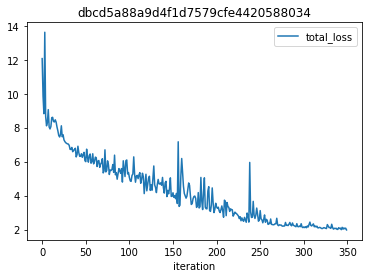

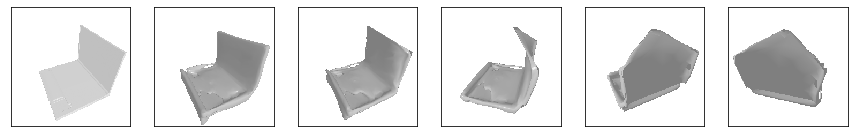

f5f5e872bf70f59983f551e0fd7d32ac
Input mesh metrics: {'2d_iou_input': 0.7512315511703491, '2d_iou_multi': 0.7091161782542864, '3d_iou': 0.3187549, '3d_iou_norm': 0, 'chamfer_L1': 0.002612740732729435, 'chamfer_L1_norm': 0}
1.0769230127334595 151.57894897460938 341.0526428222656



Refined mesh metrics: {'2d_iou_input': 0.6203073263168335, '2d_iou_multi': 0.6532603899637858, '3d_iou': 0.3255287, '3d_iou_norm': 0, 'chamfer_L1': 0.004719705320894718, 'chamfer_L1_norm': 0}


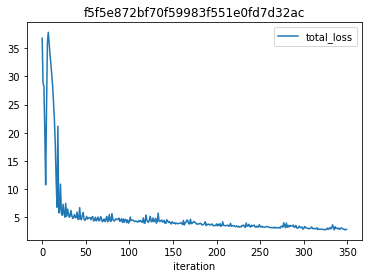

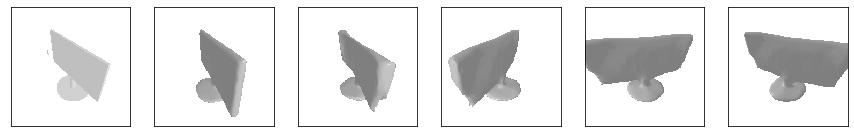

f3bfeab806cc976072052f2ed83934f0
Input mesh metrics: {'2d_iou_input': 0.8622651100158691, '2d_iou_multi': 0.7361617336670557, '3d_iou': 0.41963583, '3d_iou_norm': 0, 'chamfer_L1': 0.0045542302541434765, 'chamfer_L1_norm': 0}
1.0769230127334595 37.894737243652344 18.947368621826172



Refined mesh metrics: {'2d_iou_input': 0.721296489238739, '2d_iou_multi': 0.7198980910082659, '3d_iou': 0.4256523, '3d_iou_norm': 0, 'chamfer_L1': 0.0038775221910327673, 'chamfer_L1_norm': 0}


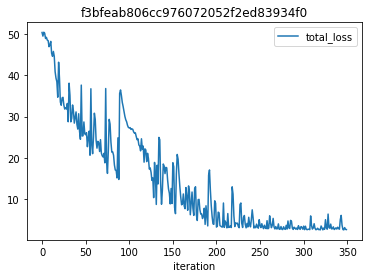

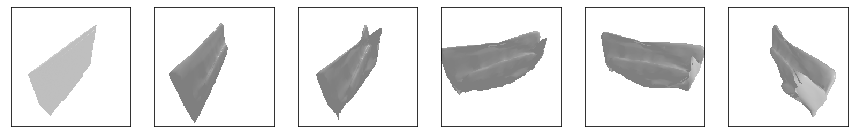

df8e098d4dbcb5b2ccc4d915989bc424
Input mesh metrics: {'2d_iou_input': 0.7913640141487122, '2d_iou_multi': 0.7672034415105978, '3d_iou': 0.22730844, '3d_iou_norm': 0, 'chamfer_L1': 0.0020156241953372955, 'chamfer_L1_norm': 0}
1.2051281929016113 37.894737243652344 113.68421173095703



Refined mesh metrics: {'2d_iou_input': 0.8618118166923523, '2d_iou_multi': 0.7846100106835365, '3d_iou': 0.12655668, '3d_iou_norm': 0, 'chamfer_L1': 0.0029123963322490454, 'chamfer_L1_norm': 0}


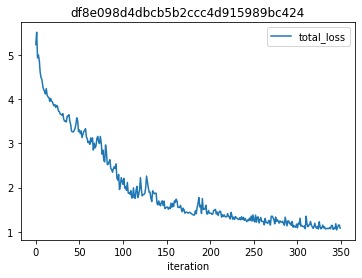

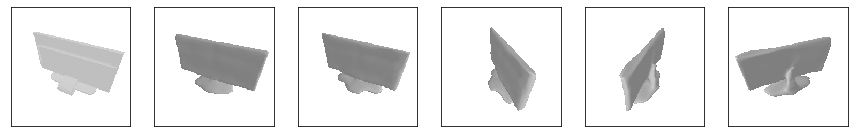

e1eac12837bcadcf44d2fe7d13c65f0c
Input mesh metrics: {'2d_iou_input': 0.8746057748794556, '2d_iou_multi': 0.8632424945632616, '3d_iou': 0.4793869, '3d_iou_norm': 0, 'chamfer_L1': 0.0009324776474386454, 'chamfer_L1_norm': 0}
1.1410256624221802 142.10525512695312 189.47369384765625



Refined mesh metrics: {'2d_iou_input': 0.8165607452392578, '2d_iou_multi': 0.8218702971935272, '3d_iou': 0.54728043, '3d_iou_norm': 0, 'chamfer_L1': 0.000734095461666584, 'chamfer_L1_norm': 0}


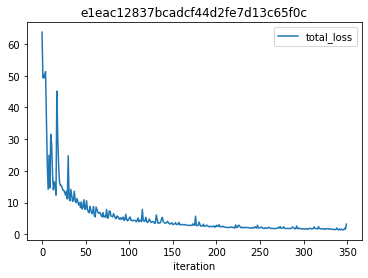

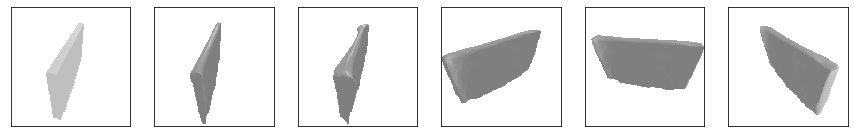

ffc224f284b63b17b0f6d70666df2668
Input mesh metrics: {'2d_iou_input': 0.9176602959632874, '2d_iou_multi': 0.7420727225641409, '3d_iou': 0.30871955, '3d_iou_norm': 0, 'chamfer_L1': 0.0021850657649338245, 'chamfer_L1_norm': 0}
1.1410256624221802 28.421052932739258 18.947368621826172



Refined mesh metrics: {'2d_iou_input': 0.6568414568901062, '2d_iou_multi': 0.5985464421100914, '3d_iou': 0.39823458, '3d_iou_norm': 0, 'chamfer_L1': 0.004742991179227829, 'chamfer_L1_norm': 0}


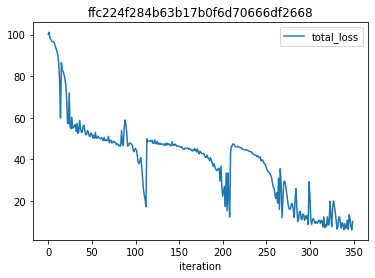

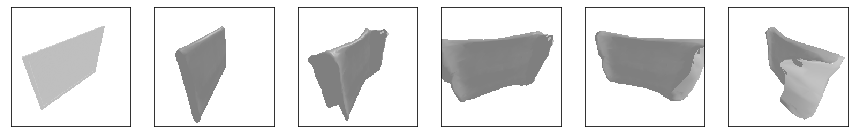

d9bac9c418667d2ba62bc668cb34e698
Input mesh metrics: {'2d_iou_input': 0.880706250667572, '2d_iou_multi': 0.6729014168183008, '3d_iou': 0.0021858746, '3d_iou_norm': 0, 'chamfer_L1': 0.001840829150751233, 'chamfer_L1_norm': 0}
1.2692307233810425 151.57894897460938 132.63157653808594



Refined mesh metrics: {'2d_iou_input': 0.7077620029449463, '2d_iou_multi': 0.6256499284257492, '3d_iou': 0.0, '3d_iou_norm': 0, 'chamfer_L1': 0.003149725729599595, 'chamfer_L1_norm': 0}


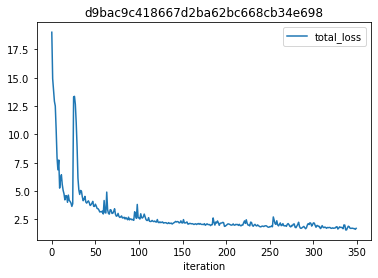

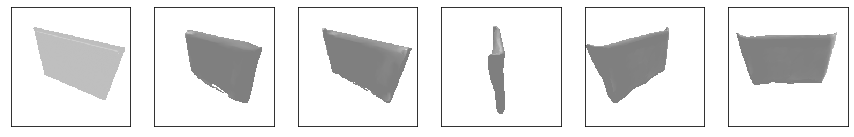

e2787b2f0dd35fccf42a90fe4baf4591
Input mesh metrics: {'2d_iou_input': 0.8459060192108154, '2d_iou_multi': 0.8249988208214442, '3d_iou': 0.74183184, '3d_iou_norm': 0, 'chamfer_L1': 0.0020459932275116444, 'chamfer_L1_norm': 0}
1.1410256624221802 151.57894897460938 189.47369384765625



Refined mesh metrics: {'2d_iou_input': 0.767910897731781, '2d_iou_multi': 0.7928763628005981, '3d_iou': 0.7244649, '3d_iou_norm': 0, 'chamfer_L1': 0.0024455413222312927, 'chamfer_L1_norm': 0}


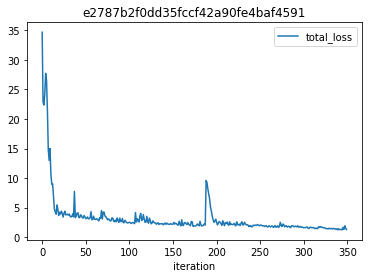

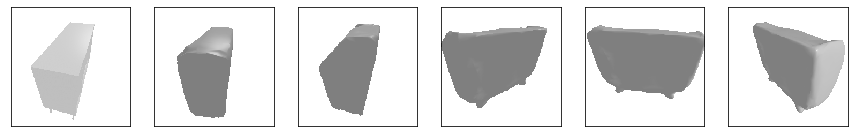

df35d335e76abf5618ba239e198ef2ba
Input mesh metrics: {'2d_iou_input': 0.7350977659225464, '2d_iou_multi': 0.5983617547899485, '3d_iou': 0.05619057, '3d_iou_norm': 0, 'chamfer_L1': 0.00535369710996747, 'chamfer_L1_norm': 0}
1.2692307233810425 9.473684310913086 265.2631530761719



Refined mesh metrics: {'2d_iou_input': 0.6372989416122437, '2d_iou_multi': 0.5583308155958852, '3d_iou': 0.07442451, '3d_iou_norm': 0, 'chamfer_L1': 0.0033152084797620773, 'chamfer_L1_norm': 0}


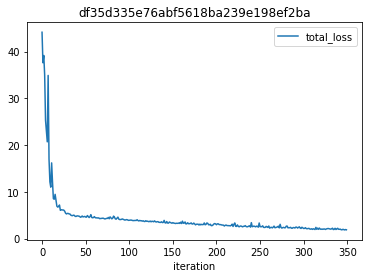

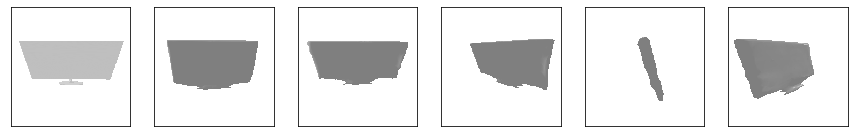

ff62121443345bf76cff78602fbd834e
Input mesh metrics: {'2d_iou_input': 0.847384512424469, '2d_iou_multi': 0.6895163270334402, '3d_iou': 0.52051425, '3d_iou_norm': 0, 'chamfer_L1': 0.003275909461081028, 'chamfer_L1_norm': 0}
1.3333332538604736 123.15789794921875 284.21051025390625



Refined mesh metrics: {'2d_iou_input': 0.7651321887969971, '2d_iou_multi': 0.6531607670088609, '3d_iou': 0.256379, '3d_iou_norm': 0, 'chamfer_L1': 0.005076399073004723, 'chamfer_L1_norm': 0}


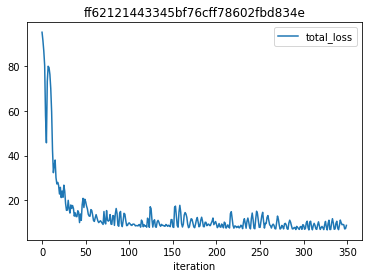

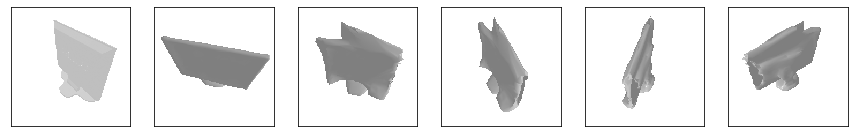

f3d6470b3f4f5ad71c7075c2bc313334
Input mesh metrics: {'2d_iou_input': 0.5912784934043884, '2d_iou_multi': 0.7461868996421496, '3d_iou': 0.32449332, '3d_iou_norm': 0, 'chamfer_L1': 0.0019106019753962755, 'chamfer_L1_norm': 0}
1.3333332538604736 142.10525512695312 341.0526428222656



Refined mesh metrics: {'2d_iou_input': 0.6602972149848938, '2d_iou_multi': 0.7910563871264458, '3d_iou': 0.41618153, '3d_iou_norm': 0, 'chamfer_L1': 0.0012611064594238997, 'chamfer_L1_norm': 0}


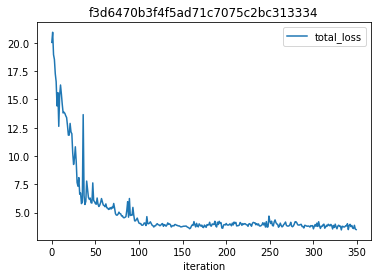

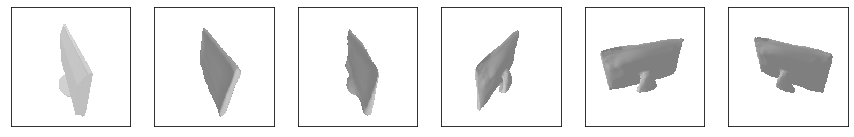

fe3e7a35b8a1c06d3bb4a1304fe504d3
Input mesh metrics: {'2d_iou_input': 0.9047271013259888, '2d_iou_multi': 0.7353273431460062, '3d_iou': 0.31220186, '3d_iou_norm': 0, 'chamfer_L1': 0.003332911990582943, 'chamfer_L1_norm': 0}
1.4615384340286255 151.57894897460938 56.842105865478516



Refined mesh metrics: {'2d_iou_input': 0.8683895468711853, '2d_iou_multi': 0.724337932964166, '3d_iou': 0.39767295, '3d_iou_norm': 0, 'chamfer_L1': 0.0025236881338059902, 'chamfer_L1_norm': 0}


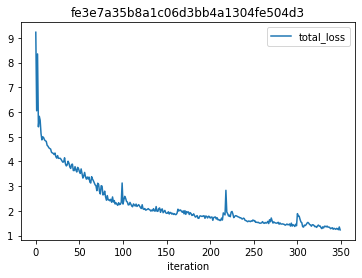

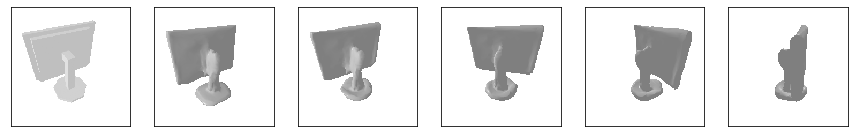

d7b87d0083bf5568fd28950562697757
Input mesh metrics: {'2d_iou_input': 0.8128432631492615, '2d_iou_multi': 0.767156045883894, '3d_iou': 0.3205271, '3d_iou_norm': 0, 'chamfer_L1': 0.0008401667582802474, 'chamfer_L1_norm': 0}
1.2051281929016113 37.894737243652344 18.947368621826172



Refined mesh metrics: {'2d_iou_input': 0.8881957530975342, '2d_iou_multi': 0.8005175242821375, '3d_iou': 0.5536065, '3d_iou_norm': 0, 'chamfer_L1': 0.0002650688402354717, 'chamfer_L1_norm': 0}


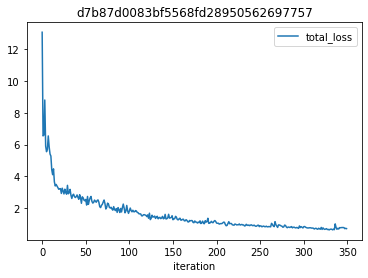

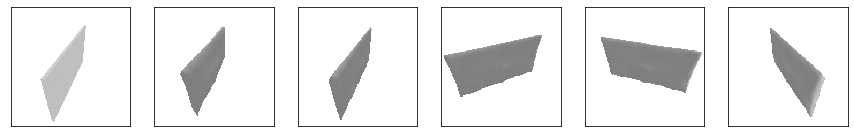

fb1ca7e50ec3013b493a838ac2ced544
Input mesh metrics: {'2d_iou_input': 0.28412121534347534, '2d_iou_multi': 0.5944431678702434, '3d_iou': 0.010830956, '3d_iou_norm': 0, 'chamfer_L1': 0.047057777643203735, 'chamfer_L1_norm': 0}
1.4615384340286255 104.21052551269531 322.1052551269531



Refined mesh metrics: {'2d_iou_input': 0.21900437772274017, '2d_iou_multi': 0.5345391252388557, '3d_iou': 0.025873506, '3d_iou_norm': 0, 'chamfer_L1': 0.025319814682006836, 'chamfer_L1_norm': 0}


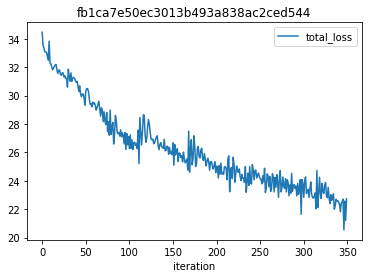

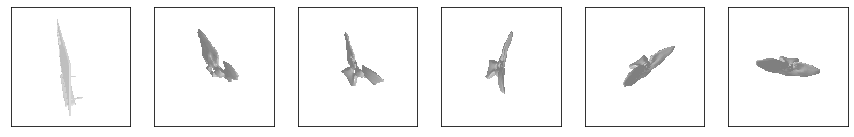

In [5]:
num_azims=20
num_elevs=20
num_dists=40

pose_s

results_df = pd.DataFrame()
for instance in instances:
    print(instance)
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    # refining using gt pose
    #gt_dist = pose_dict[instance]["dist"]
    gt_elev = pose_dict[instance]["elev"]
    gt_azim = pose_dict[instance]["azim"]
    _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
    
    
    input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                   gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                   pred_azim=gt_azim, pred_elev=gt_elev, pred_dist=gt_dist)
    instance_info = {**instance_info, **{"original_{}".format(metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
    print("Input mesh metrics: {}".format(input_metrics_dict))
    #gt_masks, rec_masks, iou_2d_scores = input_debug_dict["2d_iou_multi"]
    #visualization_tools.show_renders(gt_masks)
    #visualization_tools.show_renders(rec_masks)
    #input_img_mask, render_mask = input_debug_dict["2d_iou"]
    #visualization_tools.show_renders([input_img_mask])
    #visualization_tools.show_renders([render_mask])

    bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
    #for (dist, elev, azim, name) in [[gt_dist.item(), gt_elev, gt_azim, "gt"], [bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"]]:
    for (dist, elev, azim, name) in [[bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"]]:
    #for (dist, elev, azim, name) in [[gt_dist.item(), gt_elev, gt_azim, "gt"]]:
        print(dist, elev, azim)
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                      metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                      pred_azim=gt_azim, pred_elev=gt_elev, pred_dist=gt_dist)
        print("Refined mesh metrics: {}".format(refined_metrics_dict))
        instance_info = {**instance_info, **{"refined_{}".format(metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}
        #gt_masks, rec_masks, iou_2d_scores = refined_debug_dict["2d_iou_multi"]
        #visualization_tools.show_renders(rec_masks)
        #input_img_mask, render_mask = refined_debug_dict["2d_iou"]
        #visualization_tools.show_renders([input_img_mask])
        #visualization_tools.show_renders([render_mask])

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
display(results_df)
print(results_df.mean())